In [12]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

## Preprocesing data



1 - O primeiro passo é baixar o dataset Appa Real e o dataset UTK faces 
    - Appa real https://www.kaggle.com/datasets/abhikjha/appa-real-face-cropped
    - UTK faces https://www.kaggle.com/code/conradkleykamp/age-and-gender-prediction-cnn

2 - O segundo passo é pre-processar os dados
    2.1 Consiste primeiro em detectar as faces das imagens
    2.2 Redimencionar as imagens 
    2.3 One hot encoding.
    2.4 Data augumentation

#### 2.1 - Para deteccao de faces usaremos o "dlib"

#### 2.2 - Resizing
    A resnet requer a 224 x 224 input. Entao iremos redimencionar as imagens para 224x224 

#### 2.3 - One hot vector 
    A resnet requer que os labels de output da rede sejam convertidos em one hot vectors. 
    For this, each categorical value needs to be mapped to an
    integer value and each integer value is represented by a binary
    vector where each value is 0 except that integer numbered
    index where the value is 1. In our work, our output labels are
    already in integer format. We set the range of age to be 0 to
    100. Then each of the labels is converted to a one hot vector of
    sized 101 where the value at the index of the age is 1 and the
    rest are 0s. We have used data augmentation since our training
    dataset was not sufficiently large. For augmentation we have
    flipped, rotated, zoomed, distorted, erased some portions of
    the images and changed their color, contrast, brightness.

#### 2.4 - data augmentation  
We have used data augmentation since our training
dataset was not sufficiently large. For augmentation we have
flipped, rotated, zoomed, distorted, erased some portions of
the images and changed their color, contrast, brightness.

In [13]:
## Downloading the Appa real https://www.kaggle.com/code/amanabdullayev/age-prediction-from-photo-using-cnn-resnet50
labels_appa = pd.read_csv('appa_real/labels.csv')
labels_appa.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [2]:
## Downloading and instanciating utk faces
path = Path("utk_face/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(len(filenames))
# Viewing examples of filenames
print(filenames[:5])

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg']


In [3]:
# Shuffling the data
np.random.seed(42)
np.random.shuffle(filenames)

In [4]:
# Separating age and gender
age_labels = []
# gender_labels = []
for filename in filenames:
    temp = filename.split('_')
    age_labels.append(temp[0])
    # gender_labels.append(temp[1])

In [5]:
# Creating new dataframe 'data' with just 'image' and 'age' columns
data_utk = pd.DataFrame()
data_utk['image'], data_utk['age'] = filenames, age_labels # , data_utk['gender'] 

In [6]:
data_utk.head()

,image,age
0,49_1_0_20170104185652921.jpg.chip.jpg,49
1,17_1_0_20170109214200825.jpg.chip.jpg,17
2,17_1_4_20170103201233799.jpg.chip.jpg,17
3,29_0_4_20170103235921692.jpg.chip.jpg,29
4,26_1_2_20170116180208093.jpg.chip.jpg,26


In [8]:
# Mapping gender=0 to "Male" and gender=1 to "Female"
gender_dict = {0:"Male",1:"Female"}

In [9]:
# Viewing dtypes prior to preprocessing
print(data_utk.dtypes)

image    object
age      object
dtype: object


In [7]:
# Assigning dtypes to 'age'
data_utk = data_utk.astype({'age':'int32'}) # 'gender': 'int32'

In [11]:

import dlib
import cv2
import os
# Loading the Dlib face detector
detector = dlib.get_frontal_face_detector()

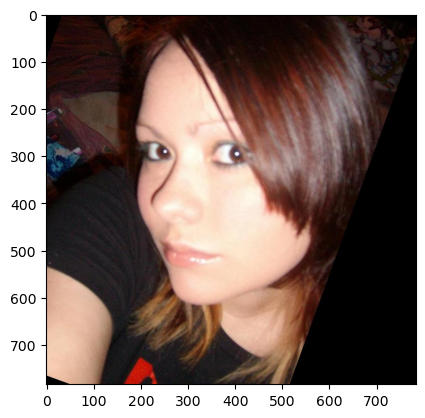

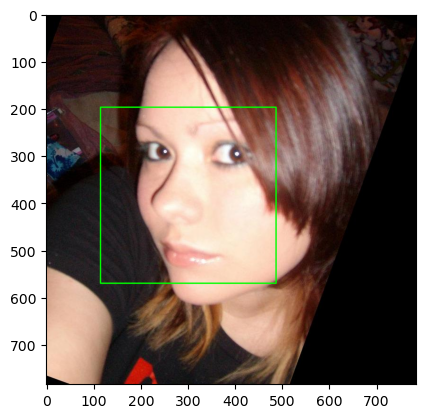

In [14]:
# Exemplo de detecção de face

diretorio_imagens_appa = 'appa_real/final_files/final_files'
arquivos_appa = os.listdir(diretorio_imagens_appa)
image_nome = arquivos_appa[1]
caminho_imagem = os.path.join(diretorio_imagens_appa,image_nome)
image = cv2.imread(caminho_imagem)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

faces = detector(image)
face = faces[0]
x, y, w, h = face.left(), face.top(), face.width(), face.height()
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# Pre-processamento do appa_real e geracao do .csv respectivo
new_appa_df = labels_appa.copy()

for image_nome in arquivos_appa:
    caminho_imagem = os.path.join(diretorio_imagens_appa,image_nome)
    image = cv2.imread(caminho_imagem)
    line_to_remove = new_appa_df.query("file_name == @image_nome")
    index = line_to_remove.index

    if line_to_remove.real_age.item() >= 90:
        new_appa_df.drop(index, inplace=True)
        continue
   
    faces = detector(image)
    if len(faces) == 0 or len(faces) > 1:
        new_appa_df.drop(index, inplace=True) # dropando linhas de imagens que nao passaram pelo pre-processamento
        continue

    new_path = os.path.join("appa_cropped_face/final_files/final_files",image_nome)
    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    nimg = image[y:y+w,x:x+h]

    if nimg.size == 0:
        new_appa_df.drop(index, inplace=True)
        continue

    cv2.imwrite(new_path,nimg) # salvando imagens pre-processadas

# Definindo os intervalos de 5
bins = range(0, 126, 5)  # De 0 a 120, com passo de 5
labels = [f'{i}-{i+5}' for i in bins[:-1]]  # Criando rótulos para os intervalos

# Atualizando a coluna idade para intervalos
new_appa_df['intervalo'] = pd.cut(new_appa_df['real_age'], bins=bins, labels=labels, right=False) 
labels = [f'{int((i+5)/5)}' for i in bins[:-1]]
new_appa_df['real_age'] = pd.cut(new_appa_df['real_age'], bins=bins, labels=labels, right=False)

new_appa_df.to_csv("appa_cropped_face/new_labels_appa.csv",index=False) # salvando o .csv alterado

In [11]:
image_nome = '8_1_0_20170109205028805.jpg.chip.jpg';
line_to_remove = data_utk.query("image == @image_nome")
print(line_to_remove)

                                      image  age
12283  8_1_0_20170109205028805.jpg.chip.jpg    8


In [13]:
# Pre-processamento do utkface e geracao do .csv respectivo
diretorio_imagens_utkface = 'utk_face/UTKFace/'
arquivos_utkface = os.listdir(diretorio_imagens_utkface)
new_utk_face = data_utk.copy()

for image_nome in arquivos_utkface:
    caminho_imagem = os.path.join(diretorio_imagens_utkface,image_nome)
    image = cv2.imread(caminho_imagem)
    line_to_remove = new_utk_face.query("image == @image_nome")
    index = line_to_remove.index

    if line_to_remove.age.item() >= 90:
        new_utk_face.drop(index, inplace=True)
        continue

    faces = detector(image)
    if len(faces) == 0 or len(faces) > 1:
        new_utk_face.drop(index, inplace=True)
        continue

    new_path = os.path.join("utkface_cropped_face/final_files",image_nome)
    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    nimg = image[y:y+w,x:x+h]

    if nimg.size == 0:
        new_utk_face.drop(index, inplace=True)
        continue
    
    cv2.imwrite(new_path,nimg) # salvando imagens pre-processadas

# Definindo os intervalos de 5
bins = range(0, 126, 5)  # De 0 a 120, com passo de 5
labels = [f'{i}-{i+5}' for i in bins[:-1]]  # Criando rótulos para os intervalos

# Atualizando a coluna idade para intervalos
new_utk_face['intervalo'] = pd.cut(new_utk_face['age'], bins=bins, labels=labels, right=False) 
labels = [f'{int((i+5)/5)}' for i in bins[:-1]]
new_utk_face['age'] = pd.cut(new_utk_face['age'], bins=bins, labels=labels, right=False)

new_utk_face.to_csv("utkface_cropped_face/new_utkface_labels.csv",index=False)

In [5]:
# Lendo o nome de todos arquivos de imagens do FGNET
fgnet_path = Path("FGNET/images/")
fgnet_filenames = list(map(lambda x: x.name, fgnet_path.glob('*.jpg')))
print(len(fgnet_filenames))
print(fgnet_filenames[:5])

1002
['001A02.JPG', '001A05.JPG', '001A08.JPG', '001A10.JPG', '001A14.JPG']


In [7]:
# Lendo a idade do nome dos arquivos e criando o dataframe respectivo
def retornarApenasParteInteiraDeString(stringEntrada):
    inteiro = 0
    while True:
        try:
            inteiro = int(stringEntrada)
            return inteiro
        except ValueError:
            stringEntrada = stringEntrada[:-1]

fgnet_age_labels = []
for filename in fgnet_filenames:
    temp = filename.split('A')[1].split('.')
    fgnet_age_labels.append(retornarApenasParteInteiraDeString(temp[0]))

data_fgnet = pd.DataFrame()
data_fgnet['image'], data_fgnet['age'] = fgnet_filenames, fgnet_age_labels
data_fgnet.head()

,image,age
0,001A02.JPG,2
1,001A05.JPG,5
2,001A08.JPG,8
3,001A10.JPG,10
4,001A14.JPG,14


In [10]:
# Pre-processamento do FGNET e geracao do .csv respectivo
diretorio_imagens_fgnet = 'FGNET/images/'
arquivos_fgnet = os.listdir(diretorio_imagens_fgnet)
new_fgnet = data_fgnet.copy()

for image_nome in arquivos_fgnet:
    caminho_imagem = os.path.join(diretorio_imagens_fgnet,image_nome)
    image = cv2.imread(caminho_imagem)
    line_to_remove = new_fgnet.query("image == @image_nome")
    index = line_to_remove.index

    if line_to_remove.age.item() >= 90:
        new_fgnet.drop(index, inplace=True)
        continue    

    faces = detector(image)
    if len(faces) == 0 or len(faces) > 1:
        new_fgnet.drop(index, inplace=True)
        continue

    new_path = os.path.join("FGNET_cropped/final_files",image_nome)
    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    nimg = image[y:y+w,x:x+h]

    if nimg.size == 0:
        new_fgnet.drop(index, inplace=True)
        continue

    cv2.imwrite(new_path,nimg) # salvando imagens pre-processadas

# Definindo os intervalos de 5
bins = range(0, 126, 5)  # De 0 a 120, com passo de 5
labels = [f'{i}-{i+5}' for i in bins[:-1]]  # Criando rótulos para os intervalos

# Atualizando a coluna idade para intervalos
new_fgnet['intervalo'] = pd.cut(new_fgnet['age'], bins=bins, labels=labels, right=False) 
labels = [f'{int((i+5)/5)}' for i in bins[:-1]]
new_fgnet['age'] = pd.cut(new_fgnet['age'], bins=bins, labels=labels, right=False)

new_fgnet.to_csv("FGNET_cropped/new_fgnet_labels.csv",index=False)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from datetime import datetime


In [13]:
#200,200,3 utk 
# variado  do appa 
from PIL import Image

In [14]:
class CSVDataset(Dataset):
    def __init__(self, csv_file, dir = "", transform = None,):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.dir = dir 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx].to_numpy()
        new_path = os.path.join(self.dir, row[0])

        #image = cv2.imread(new_path)
        image = Image.open(new_path) 

        nimage = self.transform(image)
            
        label = torch.tensor(row[1], dtype=torch.long)       

        return nimage, label 

In [15]:
batch_size  = 128
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

In [16]:
data_train_appa = CSVDataset('appa_cropped_face/new_labels_appa.csv', dir="appa_cropped_face/final_files/final_files", transform=train_transform)
data_train_utk = CSVDataset('utkface_cropped_face/new_utkface_labels.csv', dir="utkface_cropped_face/final_files", transform=train_transform)


In [17]:
import torch.utils
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
train_dataset_concat = ConcatDataset([data_train_appa, data_train_utk])

#separando em train and val 

train_size = int(0.8 * len(train_dataset_concat))  
val_size = len(train_dataset_concat) - train_size

train_dataset, val_dataset = random_split(train_dataset_concat, [train_size, val_size])

# train_loader_appa = torch.utils.data.DataLoader(
#     dataset = data_train_appa,
#     batch_size=batch_size,
#     shuffle= True
# )

# train_loader_utk = torch.utils.data.DataLoader(
#     dataset = data_train_utk,
#     batch_size = batch_size,
#     shuffle= True
# )

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    shuffle= True
)

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size=batch_size,
    shuffle= True
)



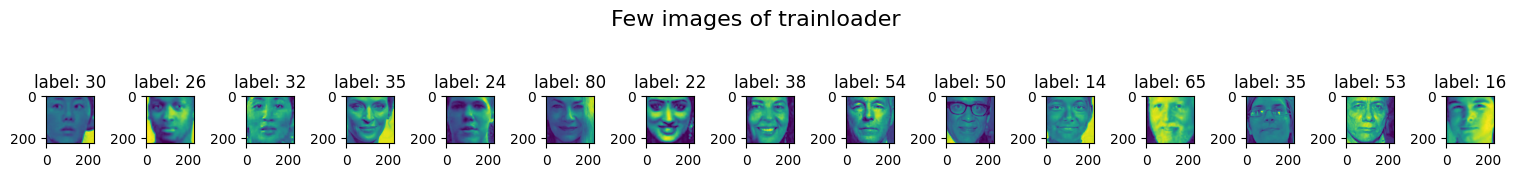

In [18]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 15
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of trainloader", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:])
    ax[i].set_title(f"label: {y[i].numpy()}")
  break


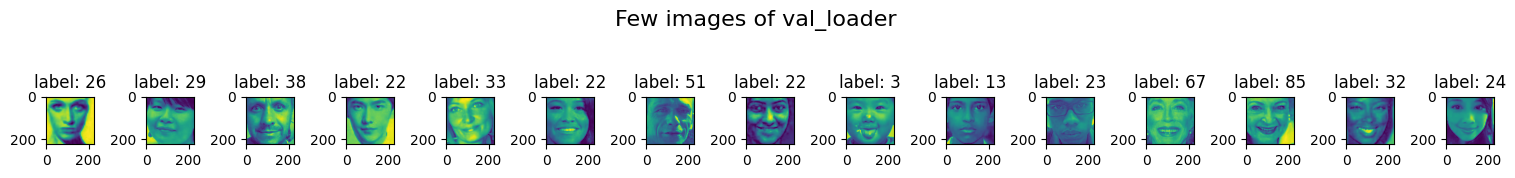

In [19]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 15
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of val_loader", fontsize=16)
for x, y in val_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:])
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
 
            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [27]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

In [28]:
def predict_module(model, test_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

In [31]:
model = models.resnet50(pretrained=True)
print(model)

/opt/anaconda3/envs/flower-tut/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/flower-tut/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
# Instanciar a rede
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features  # Número de entradas da camada totalmente conectada original
model.fc = torch.nn.Linear(num_ftrs, 101)  # Substituir pela nova camada com 101 saídas


model.to(DEVICE)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

/opt/anaconda3/envs/flower-tut/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/flower-tut/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:

# treino da rede
train_losses, test_losses = fit(model, criterion, optimizer, train_loader, val_loader, epochs = 22)
plot_losses(train_losses, test_losses)

KeyboardInterrupt: 